<a href="https://colab.research.google.com/github/umbcfloodbot/FloodBot/blob/main/Image_Based_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run this code under tf1.4. Image PreProcessing works

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
import platform
import sqlalchemy
import mysql.connector
import requests
import json
from pandas.io.json import json_normalize
import time

In [ ]:
working_dir  =("C:\\Users\Bipen\\Desktop\\open_cv\\")
src_vid_dir =("C:\\Users\Bipen\\Desktop\\open_cv\\raw_video_incrmntl\\")

In [ ]:
os.chdir(working_dir)

# Function to get TimeStamps on Video

In [ ]:
def creation_date(path_to_file):
    """
    Try to get the date that a file was created, falling back to when it was
    last modified if that isn't possible.
    See http://stackoverflow.com/a/39501288/1709587 for explanation.
    """
    if platform.system() == 'Windows':
        return os.path.getmtime(path_to_file)
   
    else:
        stat = os.stat(path_to_file)
        try:
            return stat.st_birthtime
        except AttributeError:
            # We're probably on Linux. No easy way to get creation dates here,
            # so we'll settle for when its content was last modified.
            return stat.st_mtime

# Function to convert TimeStamps on Video in UNIX

In [ ]:
#from datetime import datetime

def convts_min(ts):
    from datetime import datetime
    ts = datetime.utcfromtimestamp(ts).strftime('%Y%m%d%H%M')
    #ts_dash = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d-%H-%M')
    return ts;

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
#print(datetime.utcfromtimestamp(ts).strftime('%Y%m%d%H%M'))

In [ ]:
#from datetime import datetime

def convts_hr(ts):
    from datetime import datetime
    ts = datetime.utcfromtimestamp(ts).strftime('%Y%m%d%H')
    #ts_dash = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d-%H-%M')
    return ts;

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
#print(datetime.utcfromtimestamp(ts).strftime('%Y%m%d%H%M'))

In [ ]:
#from datetime import datetime

def convts_day(ts):
    from datetime import datetime
    ts = datetime.utcfromtimestamp(ts).strftime('%Y%m%d')
    #ts_dash = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d-%H-%M')
    return ts;

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
#print(datetime.utcfromtimestamp(ts).strftime('%Y%m%d%H%M'))

In [ ]:
#from datetime import datetime

def convts_est(ts):
    from datetime import datetime
    ts = time.strftime('%Y_%m_%d_%H:%M', time.localtime(ts))
    #ts1=time.strftime('%Y-%m-%d %H:%M', time.localtime(ts))
    #ts_dash = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d-%H-%M')
    return ts;

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
#print(datetime.utcfromtimestamp(ts).strftime('%Y%m%d%H%M'))

#time.strftime('%Y-%m-%d %H:%M', time.localtime(ts))

# Create a dataframe with List of Videos Avialable in the raw_video folder

In [ ]:
src_vid_dir="C:\\Users\\Bipen\\Desktop\\open_cv\\raw_video_incrmntl\\"
root = "C:\\Users\\Bipen\\Desktop\\open_cv\\raw_video_incrmntl\\"
mp4_vid_list =[]
mp4_vid_unix_ts = []
mp4_vid_mint_ts =[]
mp4_vid_hr_ts =[]
mp4_vid_utc =[]
mp4_vid_day_ts =[]
mp4_vid_EST_ts =[]

import os
for file in os.listdir(src_vid_dir):
    if file.endswith(".mp4"):
        file= src_vid_dir + '\\' + file
        #rint(int(creation_date(file)))
        unix_tx=int(creation_date(file))
        mp4_vid_unix_ts.append(int(unix_tx))
        mp4_vid_mint_ts.append(convts_min(int(unix_tx))) 
        mp4_vid_hr_ts.append(convts_hr(int(unix_tx))) 
        mp4_vid_list.append(os.path.join(file))
        mp4_vid_day_ts.append(convts_day(int(unix_tx)))
        mp4_vid_EST_ts.append(convts_est(int(unix_tx)))
        

# Store all the videos in TimeStamp

In [ ]:
df_mp4_vid_list = pd.DataFrame(mp4_vid_list,columns = ['Orig_Frame'] )
df_mp4_vid_unix_ts= pd.DataFrame(mp4_vid_unix_ts,columns = ['Orig_Vid_TS'] )
df_mp4_vid_utc_mnt= pd.DataFrame(mp4_vid_mint_ts,columns = ['UTC_Vid_TS_min'] )
df_mp4_vid_utc_hr= pd.DataFrame(mp4_vid_hr_ts,columns = ['UTC_Vid_TS_hr'] )
df_mp4_vid_utc_day= pd.DataFrame(mp4_vid_day_ts,columns = ['UTC_Vid_TS_day'] )
df_mp4_vid_EST_ts= pd.DataFrame(mp4_vid_EST_ts,columns = ['Vid_EST_TS'] )

In [ ]:
df_mp4 = pd.concat([df_mp4_vid_list,df_mp4_vid_unix_ts,df_mp4_vid_utc_mnt,df_mp4_vid_utc_hr,df_mp4_vid_utc_day,df_mp4_vid_EST_ts], axis=1)

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
df_mp4.shape

(656, 6)

# Some more house keeping to arrange the images and vidoes

In [ ]:
df_mp4['Video_Frame'] = df_mp4['Orig_Frame'].str[51:]
df_mp4['Video_Frame3'] = df_mp4['Orig_Frame'].str[-5:-4]
df_mp4['Frame_Name'] = df_mp4['Video_Frame'].str[4:]
df_mp4 = df_mp4[df_mp4['Video_Frame3'] == 'M']
df_mp4 = df_mp4.reset_index(drop=True)
df_mp4['Img_Frame'] = df_mp4['Video_Frame'].str[:-10]
df_mp4.drop(['Video_Frame3'], axis=1,inplace=True)
df_mp4.drop(['Orig_Frame'], axis=1, inplace=True)

In [ ]:
df_mp4.shape

(328, 8)

# Push these Record to Database for Loosely Supervised Labeling

In [ ]:
# Import dataframe into MySQL
import sqlalchemy
database_username = 'XXXXX'
database_password = 'XXXX'
database_ip       = '209.208.XXX.XXX'
database_name     = 'ec_sensors'
database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(database_username, database_password, 
                                                      database_ip, database_name))

In [ ]:
df_mp4.to_sql(con=database_connection, name='video_frame', if_exists='append', index=False)


In [ ]:
df_mp4['ID'] = (df_mp4.index+1)

# Lets look at the Weather Pattern when we have Video Recordings

In [ ]:
sql_stmnt="select distinct CAST((UNIX_TIMESTAMP(UTC_Vid_TS_day)) AS UNSIGNED) unix_day FROM ec_sensors.video_frame order by UTC_Vid_TS_day;"

In [ ]:
df_video_dt = pd.read_sql(sql_stmnt, con=database_connection)

# Create list of all the Weather Days that we have Records

In [ ]:
url = []
url1 = "https://api.darksky.net/forecast/9aa4f1df93efbffea9c020381c2f6270/42.3601,-76.7998,"
for row in df_video_dt.itertuples():
    time= row.unix_day
    url2 =str(time)
    url3="?exclude=currently,flags"  
    url.append(url1+url2+url3)

In [ ]:
df_url= pd.DataFrame(url,columns = ['URLS'])

In [ ]:
type(df_mp4)

pandas.core.frame.DataFrame

In [ ]:
df_url

,URLS
0,"https://api.darksky.net/forecast/9aa4f1df93efbffea9c020381c2f6270/42.3601,-76.7998,1579323600?exclude=currently,flags"
1,"https://api.darksky.net/forecast/9aa4f1df93efbffea9c020381c2f6270/42.3601,-76.7998,1579410000?exclude=currently,flags"
2,"https://api.darksky.net/forecast/9aa4f1df93efbffea9c020381c2f6270/42.3601,-76.7998,1579496400?exclude=currently,flags"
3,"https://api.darksky.net/forecast/9aa4f1df93efbffea9c020381c2f6270/42.3601,-76.7998,1579582800?exclude=currently,flags"
4,"https://api.darksky.net/forecast/9aa4f1df93efbffea9c020381c2f6270/42.3601,-76.7998,1579669200?exclude=currently,flags"
5,"https://api.darksky.net/forecast/9aa4f1df93efbffea9c020381c2f6270/42.3601,-76.7998,1579755600?exclude=currently,flags"
6,"https://api.darksky.net/forecast/9aa4f1df93efbffea9c020381c2f6270/42.3601,-76.7998,1579842000?exclude=currently,flags"
7,"https://api.darksky.net/forecast/9aa4f1df93efbffea9c020381c2f6270/42.3601,-76.7998,1579928400?exclude=currently,flags"
8,"https://api.darksky.net/forecast/9aa4f1df93efbffea9c020381c2f6270/42.3601,-76.7998,1580014800?exclude=currently,flags"
9,"https://api.darksky.net/forecast/9aa4f1df93efbffea9c020381c2f6270/42.3601,-76.7998,1580101200?exclude=currently,flags"


# This piece write back hourly weather for the days we had video captured.

In [ ]:
import time
i=0
for row in df_url.itertuples():
    print('Start Extracting' + str(i))
    url=row.URLS
    time.sleep(20)   
    response = requests.request("GET", url)
    DarkSky_Out=response.text
    data_parsed = json.loads(DarkSky_Out)
    df_ec_weather=json_normalize(data_parsed)
    hourly_data=  df_ec_weather['hourly.data'].values[0]
    #print('Done Waiting')
    df_dhourly_data=json_normalize(hourly_data)
    print(' Done URL Parrsing Waiting')
    time.sleep(5)
    print('DB Writing')
    df_dhourly_data.to_sql(con=database_connection, name='video_weather', if_exists='append', index=False)
    response=''
    DarkSky_Out=''
    data_parsed=''
    del df_ec_weather 
    hourly_data=''
    del df_dhourly_data
    i += i
    print('Done Looping ...')

Start Extracting0
 Done URL Parrsing Waiting
DB Writing
Done Looping ...
Start Extracting0
 Done URL Parrsing Waiting
DB Writing
Done Looping ...
Start Extracting0
 Done URL Parrsing Waiting
DB Writing
Done Looping ...
Start Extracting0
 Done URL Parrsing Waiting
DB Writing
Done Looping ...
Start Extracting0
 Done URL Parrsing Waiting
DB Writing
Done Looping ...
Start Extracting0
 Done URL Parrsing Waiting
DB Writing
Done Looping ...
Start Extracting0
 Done URL Parrsing Waiting
DB Writing
Done Looping ...
Start Extracting0
 Done URL Parrsing Waiting
DB Writing
Done Looping ...
Start Extracting0
 Done URL Parrsing Waiting
DB Writing
Done Looping ...
Start Extracting0
 Done URL Parrsing Waiting
DB Writing
Done Looping ...
Start Extracting0
 Done URL Parrsing Waiting
DB Writing
Done Looping ...
Start Extracting0
 Done URL Parrsing Waiting
DB Writing
Done Looping ...
Start Extracting0
 Done URL Parrsing Waiting
DB Writing
Done Looping ...
Start Extracting0
 Done URL Parrsing Waiting
DB Wri

# Start Open CV works now (Extarct frame @XX for Labeling)

In [ ]:
sql_stmnt_max_frm ="select max(cast(digits(frame_id) as UNSIGNED) )Last_frm from image_frame"

In [ ]:
j_max = pd.read_sql(sql_stmnt_max_frm, con=database_connection)

In [ ]:
j_max

,Last_frm
0,8934


In [ ]:
j_max= (j_max['Last_frm'].iloc[0]) 

In [ ]:
j_max = j_max + 1

In [ ]:
df_mp4.head()

,Orig_Vid_TS,UTC_Vid_TS_min,UTC_Vid_TS_hr,UTC_Vid_TS_day,Vid_EST_TS,Video_Frame,Frame_Name,Img_Frame
0,1580665256,202002021740,2020020217,20200202,2020_02_02_12:40,Rec_20200202_174020_151_M.mp4,20200202_174020_151_M.mp4,Rec_20200202_174020
1,1580668302,202002021831,2020020218,20200202,2020_02_02_13:31,Rec_20200202_183054_151_M.mp4,20200202_183054_151_M.mp4,Rec_20200202_183054
2,1580668618,202002021836,2020020218,20200202,2020_02_02_13:36,Rec_20200202_183627_151_M.mp4,20200202_183627_151_M.mp4,Rec_20200202_183627
3,1580669740,202002021855,2020020218,20200202,2020_02_02_13:55,Rec_20200202_185509_151_M.mp4,20200202_185509_151_M.mp4,Rec_20200202_185509
4,1580670156,202002021902,2020020219,20200202,2020_02_02_14:02,Rec_20200202_190205_151_M.mp4,20200202_190205_151_M.mp4,Rec_20200202_190205


In [ ]:
df_mp4.shape

(328, 8)

In [ ]:
pwd

'C:\\Users\\Bipen\\Desktop\\open_cv\\frm_128'

In [ ]:
working_dir  = ("C:\\Users\Bipen\\Desktop\\open_cv\\")
os.chdir(working_dir)

# Opens the Video file
frame_ts = []
frame_id = []
video_id = []

#Change it to Last frameID in the storage eg last extract frame ID was 
j=j_max 
root='C:\\Users\Bipen\\Desktop\\open_cv\\raw_video_incrmntl\\'
for row in df_mp4.itertuples():
    vd_frm=str(root) + str(row.Video_Frame)
    vdo_id=str(row.Video_Frame)
    img_frm = str(row.Img_Frame)
    #print(vd_frm)
    cap= cv2.VideoCapture(vd_frm)
    i=1
    while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False:
                break   
            if i%25 == 0:
                # Saves image of the current frame in jpg file
                name = './frm_128/frame' + str(j) + '.jpg'
                img_id = 'frame' + str(j) + '.jpg'
                #print(name)
                
                cv2.imwrite('kang'+str(i)+'.png',frame)
                j+=1 
                cv2.imwrite(name,frame)
                frame_ts.append(img_frm)
                frame_id.append(img_id)
                video_id. append(vdo_id)

            i+=1
           
 
    cap.release()
    
    cv2.destroyAllWindows()

In [ ]:
df_frmTs= pd.DataFrame(frame_ts,columns = ['Frame_Ts'] )
df_frmID= pd.DataFrame(frame_id,columns = ['Frame_Id'] )
df_video_id= pd.DataFrame(video_id,columns = ['video_frame'] )

In [ ]:
myFrameNumber = 50
cap = cv2.VideoCapture("video.mp4")

# get total number of frames
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

# check for valid frame number
if myFrameNumber >= 0 & myFrameNumber <= totalFrames:
    # set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES,myFrameNumber)

while True:
    ret, frame = cap.read()
    cv2.imshow("Video", frame)
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

In [ ]:
df_img =  pd.concat([df_frmTs,df_frmID,df_video_id], axis=1)

In [ ]:
df_img

,Frame_Ts,Frame_Id,video_frame
0,Rec_20200202_174020,frame8935.jpg,Rec_20200202_174020_151_M.mp4
1,Rec_20200202_174020,frame8936.jpg,Rec_20200202_174020_151_M.mp4
2,Rec_20200202_174020,frame8937.jpg,Rec_20200202_174020_151_M.mp4
3,Rec_20200202_174020,frame8938.jpg,Rec_20200202_174020_151_M.mp4
4,Rec_20200202_174020,frame8939.jpg,Rec_20200202_174020_151_M.mp4
...,...,...,...
6946,Rec_20200207_000620,frame15881.jpg,Rec_20200207_000620_151_M.mp4
6947,Rec_20200207_000620,frame15882.jpg,Rec_20200207_000620_151_M.mp4
6948,Rec_20200207_000620,frame15883.jpg,Rec_20200207_000620_151_M.mp4
6949,Rec_20200207_000620,frame15884.jpg,Rec_20200207_000620_151_M.mp4


# Store the Image Frames on Database too.

In [ ]:
df_img.to_sql(con=database_connection, name='image_frame', if_exists='append', index=False)

In [ ]:
df_img = pd.read_sql('select * from image_frame',con=database_connection)

In [ ]:
df_img.head(2)

,Frame_Ts,Frame_Id,video_frame
0,Rec_20200118_162340,frame0.jpg,Rec_20200118_162340_151_M.mp4
1,Rec_20200118_162340,frame1.jpg,Rec_20200118_162340_151_M.mp4


# This is a big Query to Label the Frame and weith condition

In [ ]:
df_img

'select * from image_frame'

# Resize Images to 128 x 128 (required size for MobileNetV2)

In [ ]:
pwd

'C:\\Users\\Bipen\\Desktop\\open_cv\\frm_128'

In [ ]:
working_dir  =("C:\\Users\\Bipen\Desktop\\open_cv\\frm_128")
#C:\Users\Bipen\Desktop\open_cv\frm_128
os.chdir(working_dir)
img_fldr="C:\\Users\\Bipen\\Desktop\\open_cv\\frm_128\\"
#for row in df_img.head(2).itertuples():
for row in df_img.itertuples():
    img_frm=str(img_fldr) + str(row.Frame_Id)
    #img_frm = str(row.Orig_Fname)
    #print(img_frm)
    img = cv2.imread(img_frm)
    #print('Here')
    img_scaled = cv2.resize(img, (128,128), interpolation = cv2.INTER_CUBIC)
    cv2.imwrite(img_frm,img_scaled,)

In [ ]:
working_dir  =("C:\\Users\Bipen\\Desktop\\open_cv\\FloodClass\\\minor_flood\\")
os.chdir(working_dir)

In [ ]:
sel_stmt='select * from FLOOD_LABEL'

In [ ]:
df_img_label =pd.read_sql(sel_stmt, con=database_connection)

In [ ]:
df_img_label.shape

(15886, 3)

In [ ]:
df_img_label.shape

(8935, 3)

In [ ]:
minor_flood_df = df_img_label[df_img_label['Flood_Label'] == 'Minor Flood']
no_flood_df = df_img_label[df_img_label['Flood_Label'] == 'No Flood']
flood_df = df_img_label[df_img_label['Flood_Label'] == 'Flood']

In [ ]:
minor_flood = minor_flood_df['frame_id'].tolist()

In [ ]:
flood = flood_df['frame_id'].tolist()
no_flood = no_flood_df['frame_id'].tolist()
minor_flood = minor_flood_df['frame_id'].tolist()

In [ ]:
minor_flood

In [ ]:
print ('Total Flood Label Images are: ' + str(len(flood)))


Total Flood Label Images are: 322


In [ ]:
print ('Total No Flood Label Images are: ' + str(len(no_flood)))

Total No Flood Label Images are: 13124


In [ ]:
print ('Total Minor Flood Label Images are: ' + str(len(minor_flood)))

Total Minor Flood Label Images are: 2440


In [ ]:
flood_df

,precipIntensity,frame_id,Flood_Label
3808,0.0912,frame3808.jpg,Flood
3809,0.0912,frame3809.jpg,Flood
3810,0.0912,frame3810.jpg,Flood
3811,0.0912,frame3811.jpg,Flood
3812,0.0912,frame3812.jpg,Flood
...,...,...,...
4107,0.0690,frame4107.jpg,Flood
4108,0.0690,frame4108.jpg,Flood
4109,0.0690,frame4109.jpg,Flood
4110,0.0690,frame4110.jpg,Flood


No handles with labels found to put in legend.


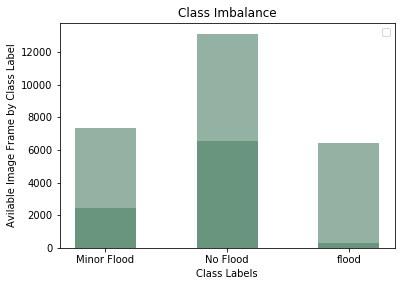

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# Make a fake dataset:
height = [len(minor_flood), len(no_flood),len(flood)]
height1 = [(len(minor_flood)*3), (len(no_flood)/2),(len(flood)*20)]
bars = ('Minor Flood', 'No Flood', 'flood')
#plt.bar(r1, bars1, width = barWidth, color = (0.3,0.1,0.4,0.6), label='Flood')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height,width = .5, color = (0.3,0.5,0.4,0.6))
plt.bar(y_pos, height1,width = .5, color = (0.3,0.5,0.4,0.6)) 
# Create names on the x-axis
plt.xticks(y_pos, bars)


# Add title and axis names
plt.title('Class Imbalance')
plt.xlabel('Class Labels')
plt.ylabel('Avilable Image Frame by Class Label')

plt.legend()


# Adjust the margins
plt.subplots_adjust(bottom= 0.2, top = 0.98)
# Show graphic
plt.show()


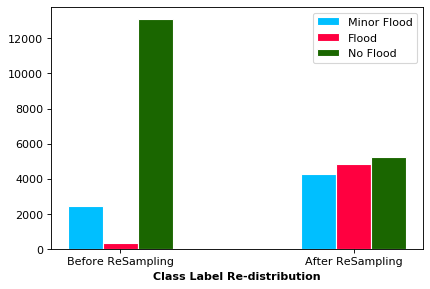

In [ ]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.15

from matplotlib.pyplot import figure
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')

#height = [len(minor_flood), len(no_flood),len(flood)]
#height1 = [(len(minor_flood)*3), (len(no_flood)/2),(len(flood)*5)]
# set height of bar
bars1 = [len(minor_flood), (len(minor_flood)*1.75)]
bars2 = [len(flood), len(flood)*15]
bars3 = [len(no_flood), len(no_flood)/2.5]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#00bfff', width=barWidth, edgecolor='white', label='Minor Flood')
plt.bar(r2, bars2, color='#ff0040', width=barWidth, edgecolor='white', label='Flood')
plt.bar(r3, bars3, color='#1a6600', width=barWidth, edgecolor='white', label='No Flood')
 
# Add xticks on the middle of the group bars
plt.xlabel('Class Label Re-distribution', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Before ReSampling', 'After ReSampling'])
 
# Create legend & Show graphic
plt.legend()
plt.show()


In [ ]:
flood[7:12]

['frame3815.jpg',
 'frame3816.jpg',
 'frame3817.jpg',
 'frame3818.jpg',
 'frame3819.jpg']

# SECTION (FLOOD IMAGE LABELING)

### This moves all the File to Flood Folder

In [ ]:
working_dir  =("C:\\Users\\Bipen\\Desktop\\open_cv\\frm_128\\")
os.chdir(working_dir)

src_fldr= 'C:\\Users\\Bipen\\Desktop\\open_cv\\frm_128\\'
tgt_fldr = 'C:\\Users\\Bipen\Desktop\\open_cv\\FloodClass\\flood\\'


import shutil, os
files = flood
for f in files:
    src= (src_fldr + f)
    tgt= (tgt_fldr + f)
    #print(src)
    #print(tgt)
    shutil.move(src, tgt)

### This moves all the File to Minor Flood Folder

In [ ]:
working_dir  =("C:\\Users\\Bipen\\Desktop\\open_cv\\frm_128\\")
os.chdir(working_dir)

src_fldr= 'C:\\Users\\Bipen\\Desktop\\open_cv\\frm_128\\'
tgt_fldr = 'C:\\Users\\Bipen\Desktop\\open_cv\\FloodClass\\minor_flood\\'


import shutil, os
files = minor_flood
for f in files:
    src= (src_fldr + f)
    tgt= (tgt_fldr + f)
    #print(src)
    #print(tgt)
    shutil.move(src, tgt)

###  This moves all the File to No Flood Folder

In [ ]:
working_dir  =("C:\\Users\\Bipen\\Desktop\\open_cv\\frm_128\\")
os.chdir(working_dir)

src_fldr= 'C:\\Users\\Bipen\\Desktop\\open_cv\\frm_128\\'
tgt_fldr = 'C:\\Users\\Bipen\Desktop\\open_cv\\FloodClass\\no_flood\\'


import shutil, os
files = no_flood
for f in files:
    src= (src_fldr + f)
    tgt= (tgt_fldr + f)
    #print(src)
    #print(tgt)
    shutil.move(src, tgt)

# SECTION : OBJECT DETECTION 

###  These images will be used for Object Detection

In [ ]:
sel_obj_det_stmt="SELECT * FROM FLOOD_LABEL WHERE FLOOD_label  in ('Flood','Minor Flood')  ORDER BY RAND() LIMIT 2000"

In [ ]:
df_obj_det =pd.read_sql(sel_obj_det_stmt, con=database_connection)

In [ ]:
obj_detct = df_obj_det['frame_id'].tolist()

In [ ]:
working_dir  =("C:\\Users\\Bipen\\Desktop\\open_cv\\frm_save_orig")
os.chdir(working_dir)

src_fldr= 'C:\\Users\\Bipen\Desktop\\open_cv\\frm_save_orig\\'
tgt_fldr = 'C:\\Users\\Bipen\\Desktop\\open_cv\\flood_obj\\'


import shutil, os
files = obj_detct
for f in files:
    src= (src_fldr + f)
    tgt= (tgt_fldr + f)
    #print(src)
    #print(tgt)
    shutil.copy(src, tgt)

In [ ]:
df_obj_det

,precipIntensity,frame_id,Flood_Label
0,0.0189,frame9402.jpg,Minor Flood
1,0.0206,frame4192.jpg,Minor Flood
2,0.0834,frame3907.jpg,Flood
3,0.0189,frame9236.jpg,Minor Flood
4,0.0189,frame9129.jpg,Minor Flood
...,...,...,...
1995,0.0189,frame9340.jpg,Minor Flood
1996,0.0250,frame44.jpg,Minor Flood
1997,0.0076,frame476.jpg,Minor Flood
1998,0.0252,frame10184.jpg,Minor Flood


In [ ]:
obj_detct

In [ ]:
df_obj_det.to_sql(con=database_connection, name='image_obj_detect_list', if_exists='append', index=False)

In [ ]:
sel_URL_stmt="select CONCAT('http://209.208.111.221/ecsensors/img/flood_obj/' , frame_id)URL from image_obj_detect_list

In [ ]:
df_URL_obj_det =pd.read_sql(sel_URL_stmt, con=database_connection)

In [ ]:
df_URL_obj_det

In [ ]:
image_urls  = []

for row in df_URL_obj_det.itertuples():
    url=str(row.URL)
    URLS.append(url)

In [ ]:
len(URLS)

2000

In [ ]:
URLS
